# Training a Neural Network for Computer Model Emulation

### Import necessary libraries 

In [8]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

import seaborn as sns
sns.set()
from pandas.plotting import scatter_matrix
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
from calculations_load import *
from configurations import *

In [11]:
# Get all the observables list

nobs        =  0
observables =  []
obs_name    =  []

for obs, cent_list in obs_cent_list['Pb-Pb-2760'].items():
    if obs not in active_obs_list['Pb-Pb-2760']:
        continue
    observables.append(obs)
    n = np.array(cent_list).shape[0]
    for i in cent_list:
        obs_name.append(f'{obs}_{i}')
    #self._slices[obs] = slice(self.nobs, self.nobs + n)
    nobs += n

In [12]:
#prepare the directories for model design and outputs
#run this cell only once, or else it will hang!
#! sh prepare.sh

### Loading Computer Model inputs and outputs

In [13]:
system_str = 'Pb-Pb-2760'
design_file = 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat'
design = pd.read_csv(design_file)
design = design.drop("idx", axis=1)

#delete bad design points
drop_indices = list(delete_design_pts_set)
design = design.drop(drop_indices)

#choose features (inputs)
#feature_cols = ['norm', 'trento_p'] #specific choices
feature_cols = design.keys().values #all of them 
n_features = len(feature_cols)

X = design[feature_cols]

n_design = SystemsInfo["Pb-Pb-2760"]["n_design"]
npt = n_design - len(delete_design_pts_set)
obs = 'dNch_deta' #choose the observable we want to emulate

Y = np.array([])

for pt in range(npt):
    for obs in active_obs_list['Pb-Pb-2760']:
        Y = np.append( Y, trimmed_model_data[system_str][pt, idf][obs]['mean'][:], axis=0)
Y = Y.reshape(X.shape[0], -1)

In [14]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 17)
Y.shape : (485, 110)


## Splitting the inputs and outputs into a training and testing set

Then, scaling all of the inputs and outputs to (0, 1)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

#X_scaler = StandardScaler().fit(X_train)
#Y_scaler = StandardScaler().fit(Y_train)
X_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
Y_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(Y_train)

X_train_sc = X_scaler.transform(X_train)
X_test_sc = X_scaler.transform(X_test)

Y_train_sc = Y_scaler.transform(Y_train)
Y_test_sc = Y_scaler.transform(Y_test)

### The cell below constructs the neural network

In [17]:
# n_hidden = 0 # number of hidden layers

# model = keras.Sequential()
# model.add(layers.Dense(50, input_dim=X.shape[1], activation='tanh'))
# for n in range(n_hidden):
#     model.add(layers.Dense(20, activation='tanh'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(Y.shape[1], activation='tanh'))
# model.summary()

In [69]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout
dropout_rate = 0.1
def model_fn():
    inputs = Input(shape=(X.shape[1],))
    x = Dense(100, activation='sigmoid')(inputs)
    x = Dropout(dropout_rate)(x, training=True)
    #x = Dense(20, activation='tanh')(x)
    x = Dense(Y.shape[1], activation='tanh')(x)
   # x = Dropout(dropout_rate)(x, training=True)
    outputs = x
    
    model = Model(inputs, outputs)
#model.compile(loss="mean_squared_error", optimizer='adam')
    model.compile(loss="huber_loss", optimizer='adam', metrics=["mean_absolute_error"])
    model.summary()
    return model

In [70]:
# compile the keras model
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model=model_fn()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 17)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               1800      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 110)               11110     
Total params: 12,910
Trainable params: 12,910
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.fit(X_train_sc, Y_train_sc, epochs=500, batch_size=50,verbose=0)

In [72]:
import numpy as np
predictions = []
sample_size = 1000
for t in range(sample_size):
    predictions.append(model.predict(X_test_sc))
   # pred_array = np.array(predictions)
   # print(pred_array.shape)
#prediction_df = pd.DataFrame()
#prediction_std= pd.DataFrame()
pred_array = np.array(predictions)
prediction_df= np.mean(pred_array,axis=0)
prediction_sd= np.std(pred_array,axis=0)
#prediction_df['std'] = pred_array.std(axis=0)

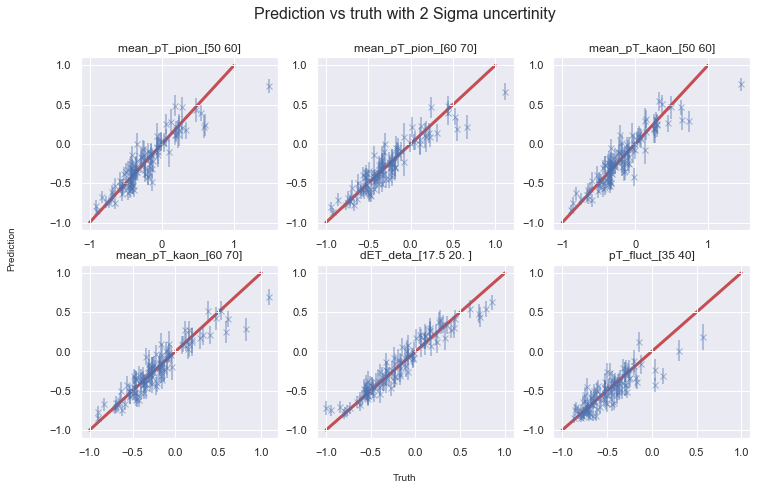

In [88]:
truth = np.linspace(-1, 1, 100)
obs_indices = [60, 61, 68, 69, 15, 85]

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('Prediction vs truth with 2 Sigma uncertinity', fontsize=16)
fig.text(0.5, 0.04, 'Truth', ha='center')
fig.text(0.04, 0.5, 'Prediction', va='center', rotation='vertical')
for i, obs_ind in enumerate(obs_indices):
    ax = axes.flatten()[i]
    ax.set_title(obs_name[obs_ind])
    ax.plot(truth, truth, c='r', lw=3, zorder=-1)
    ax.errorbar(Y_test_sc[:, obs_ind], prediction_df[:, obs_ind],yerr=2*prediction_sd[:,obs_ind],alpha=0.5,fmt='x')

In [74]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(Y_test_sc,prediction_df)

In [75]:
coefficient_of_dermination

0.8255658199949023

In [76]:
import numpy as np
def root_mean_squre_percentage_error(y_true, y_pred,feature_loc): 
    y_true, y_pred = Y_scaler.inverse_transform(y_true)[:,feature_loc], Y_scaler.inverse_transform(y_pred)[:,feature_loc]
    return np.sqrt(np.mean(np.square((y_true - y_pred)/ y_true))) * 100

In [77]:
#from sklearn.metrics import mean_squared_error
def plot_rmse_bp(observable='dN_dy_pion'):
    # Get all the observables list
    prediction_df_bp=pd.DataFrame()
    nobs        =  0
    observables =  []
    obs_name    =  []
    prediction_rmse=pd.DataFrame()
    for obs, cent_list in obs_cent_list['Pb-Pb-2760'].items():
        nobs += nobs
        if obs !=observable:
            continue
        for k,i in enumerate(cent_list):
            obs_name.append(f'{obs}_{i}')
            new=prediction_df[:,nobs+k]-Y_test_sc[:,nobs+k]
        #self._slices[obs] = slice(self.nobs, self.nobs + n)
          #  print(np.mean(-Y_test_sc[:,i],axis=0))
           # print(prediction_df[:,i]-Y_test_sc[:,i])
            prediction_df_bp[f'{i}']=new
            #print(mean_squared_error(prediction_df[:,nobs+k],Y_test_sc[:,nobs+k]))
            prediction_rmse[f'{i}']=[root_mean_squre_percentage_error(Y_test_sc,prediction_df,nobs+k)]
          #  prediction_df_bp[i]=
          #  print(prediction_df_bp.shape)
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    for i in [0,1]:
        ax=axes.flatten()[i]
        if (i==0):
            boxplot = prediction_df_bp.boxplot(rot=90,ax=ax,showfliers=False)
            ax.set_xticklabels([])
            ax.set_ylabel('Normalized Residuals',fontsize=15)
        if (i==1):
            ax.scatter(prediction_rmse.keys(),prediction_rmse.iloc[0])
            ax.set_xticklabels(labels=prediction_rmse.keys(), rotation=90, ha='right')
            ax.set_ylabel('RMS % error',fontsize=15)
            #scatter_plt = prediction_rmse.plot.scatter(rot=90,ax=ax)
    fig.text(0.04, 0.5, observable, va='center', rotation='vertical',fontsize=16)

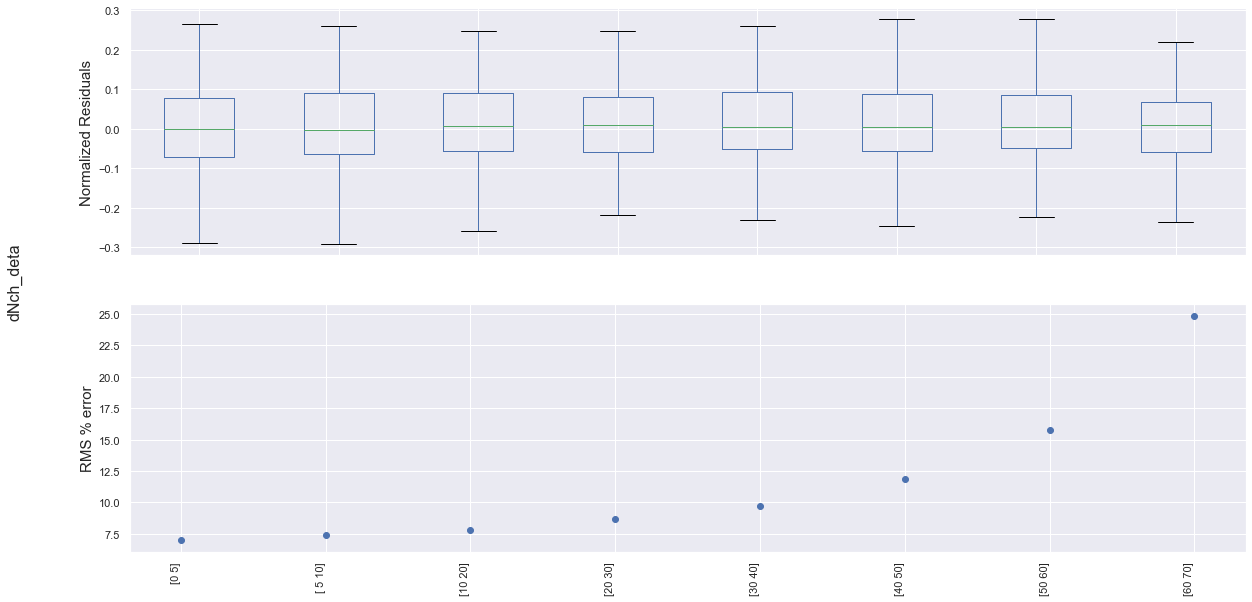

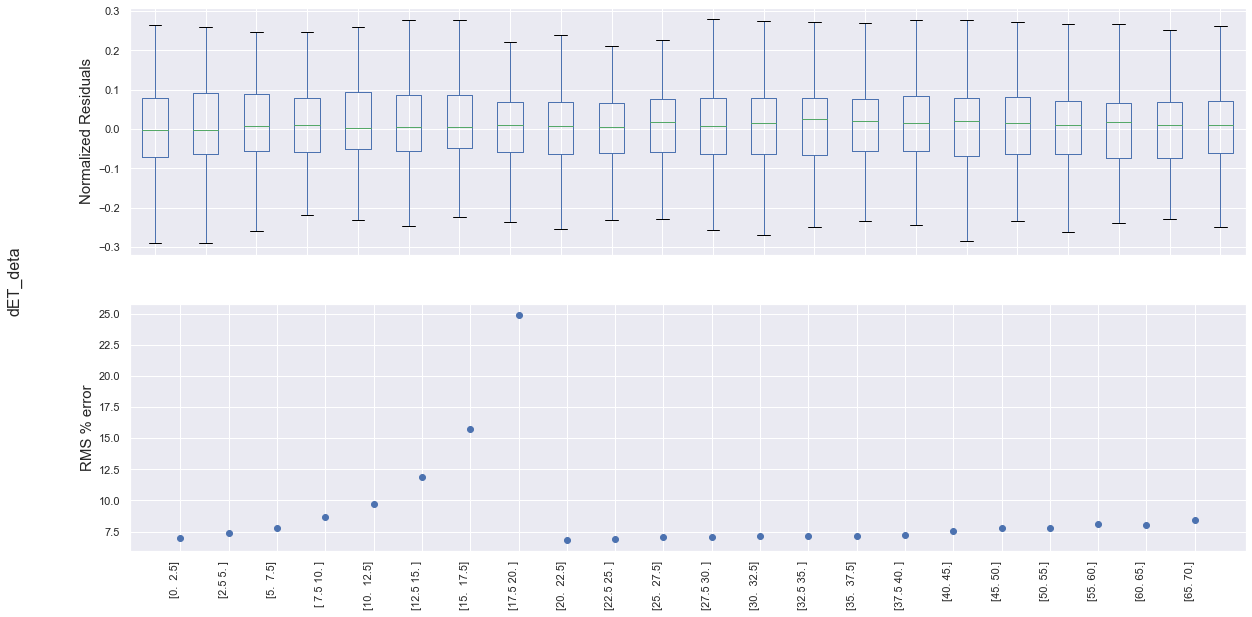

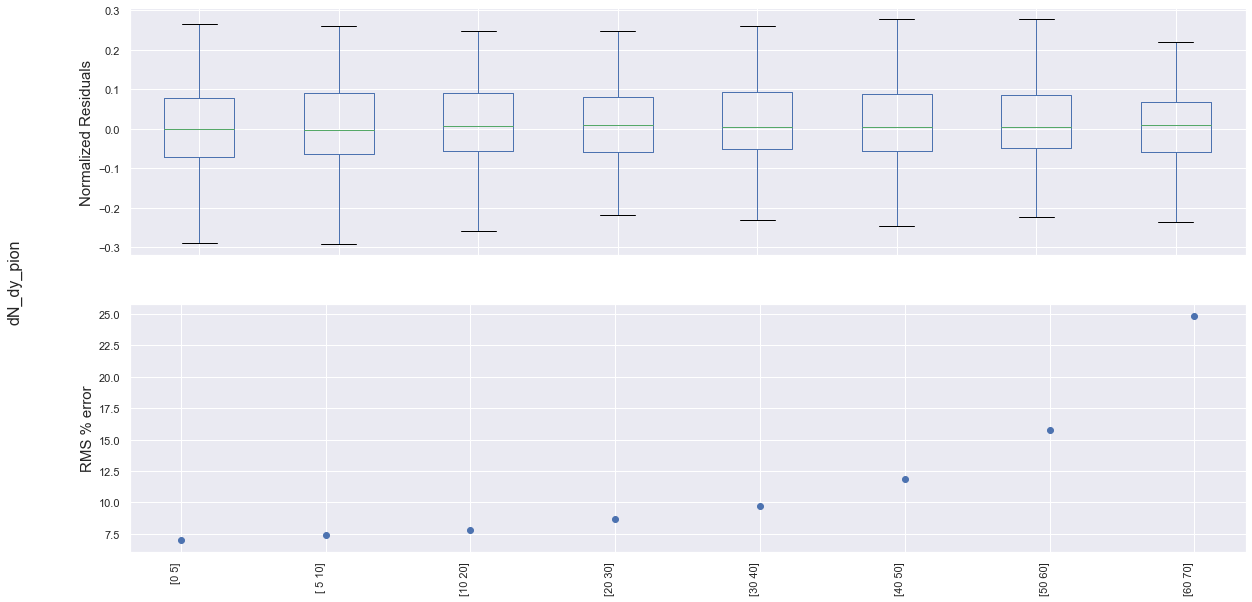

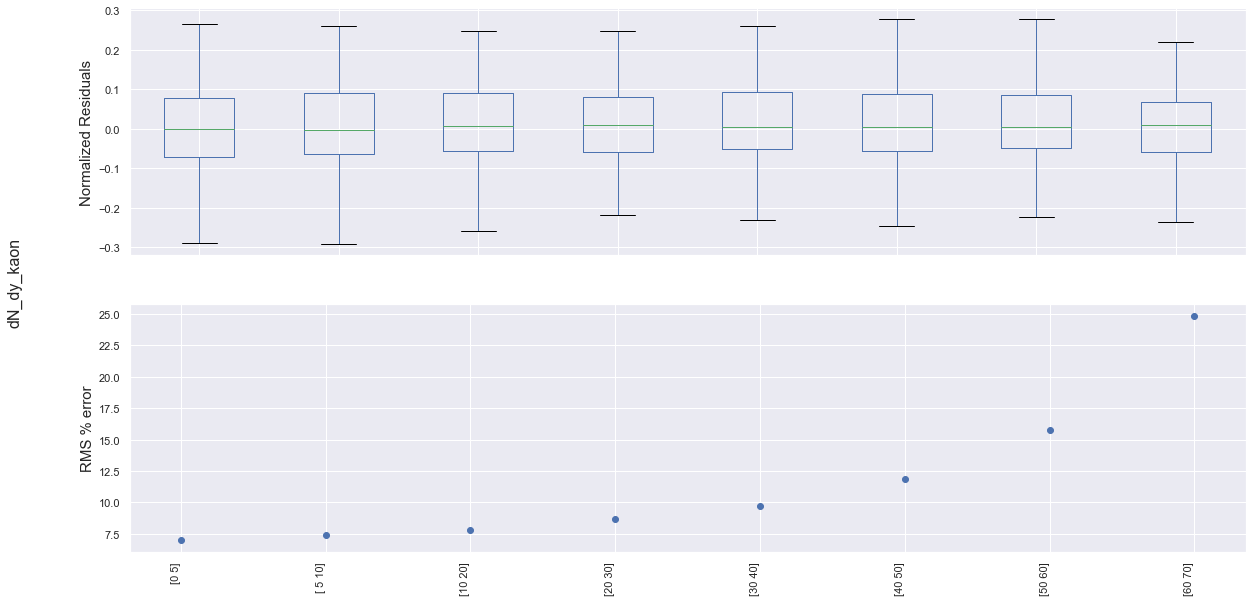

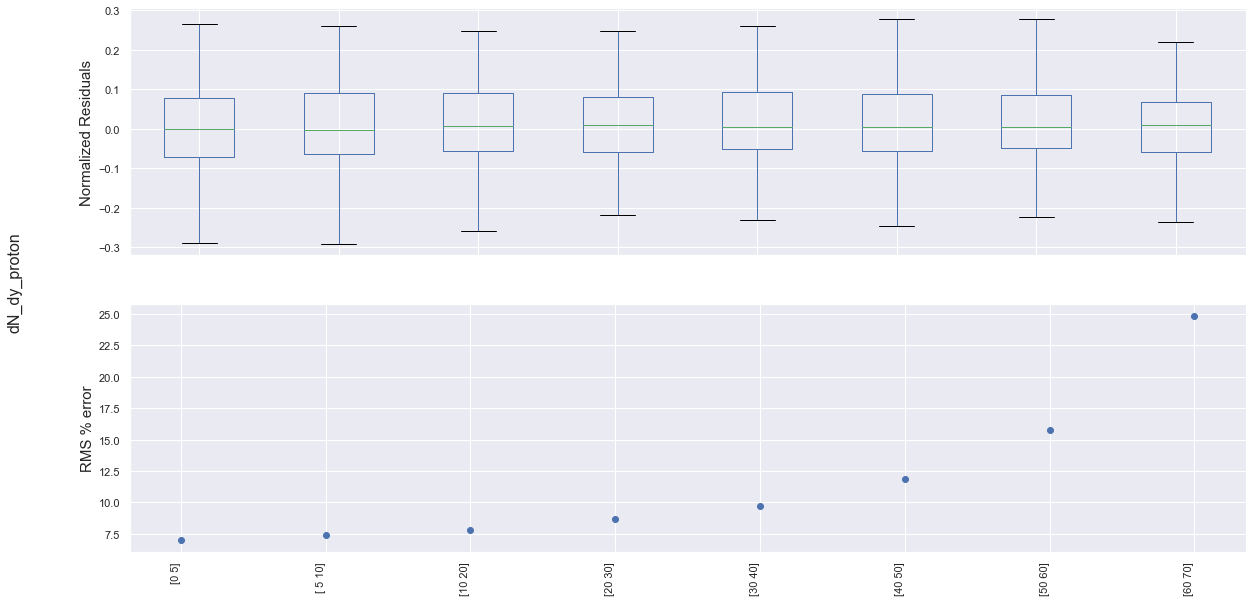

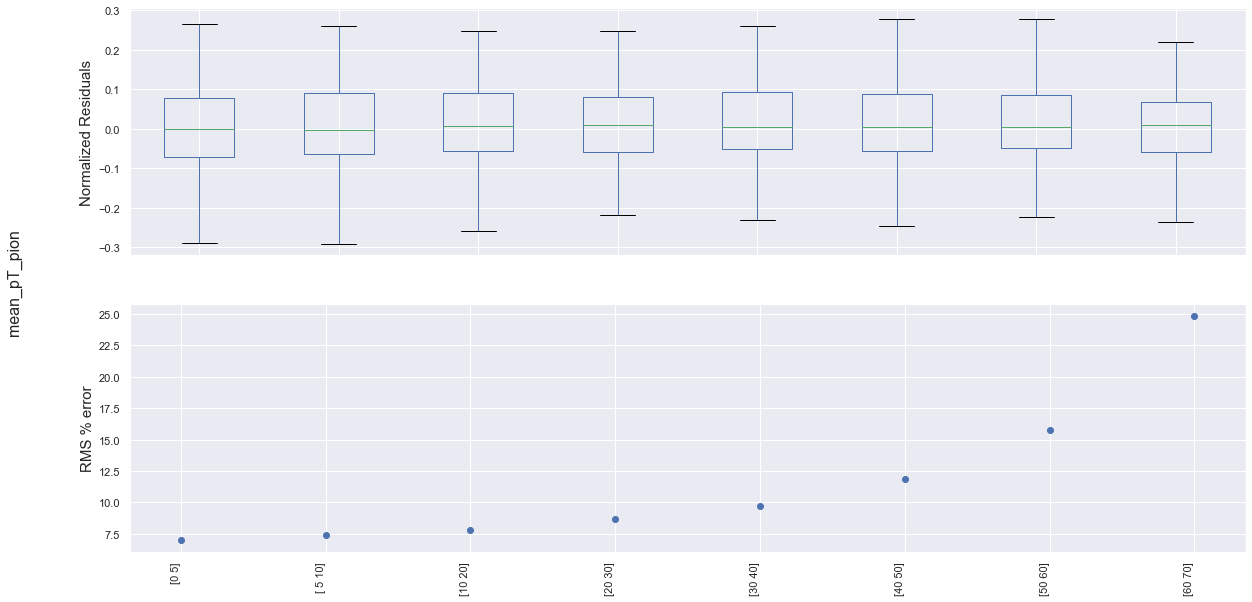

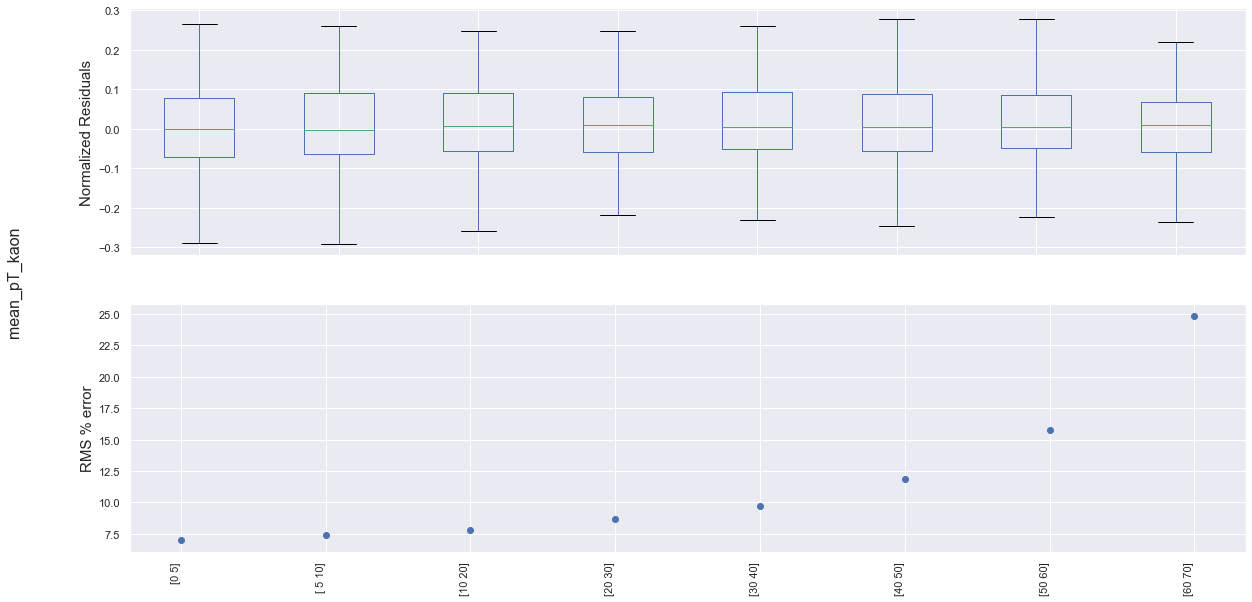

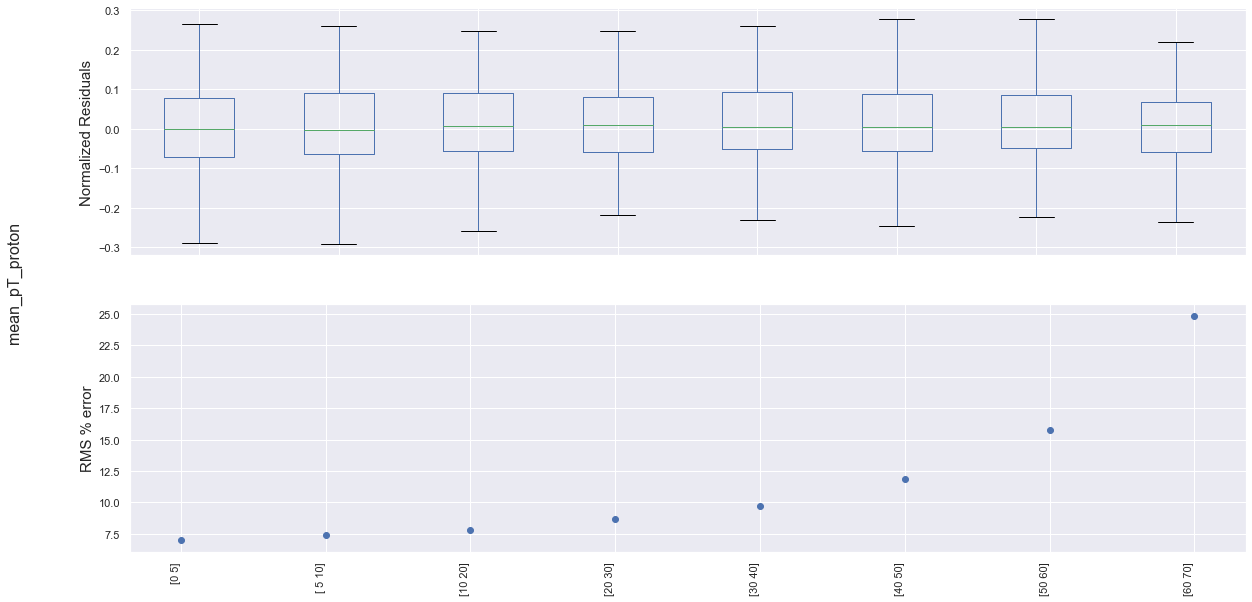

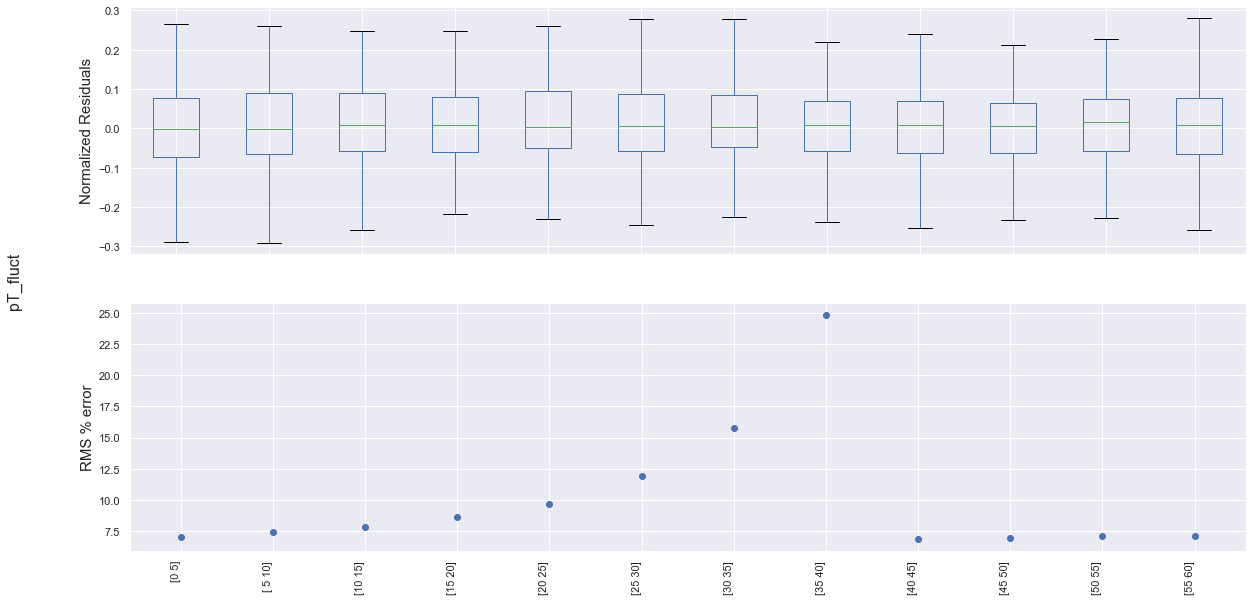

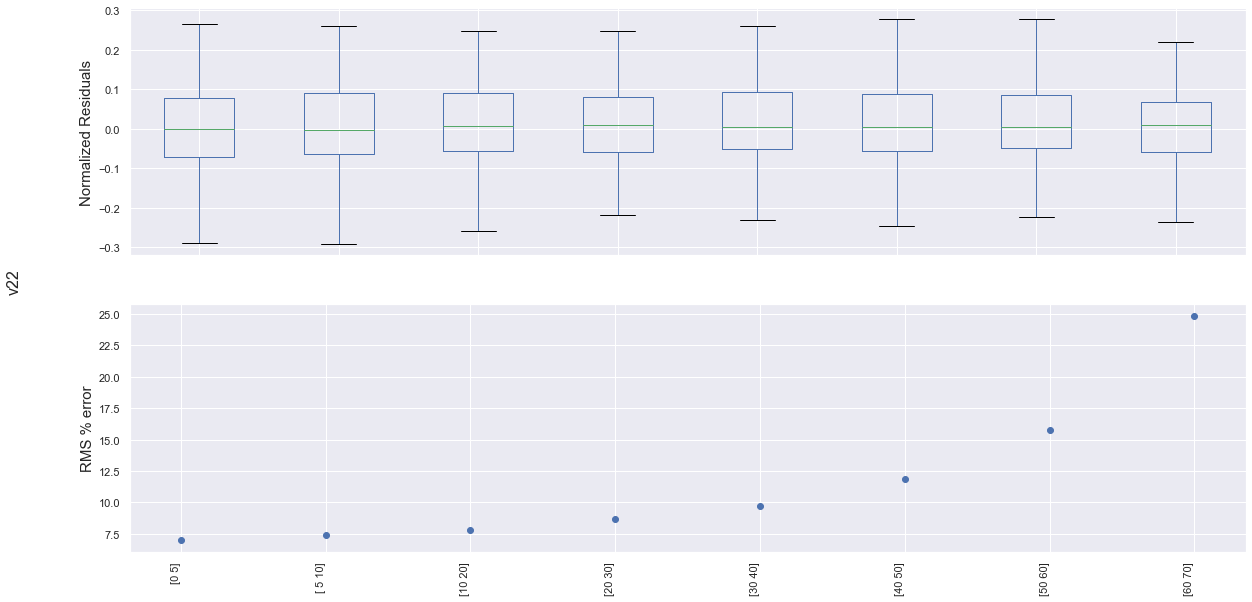

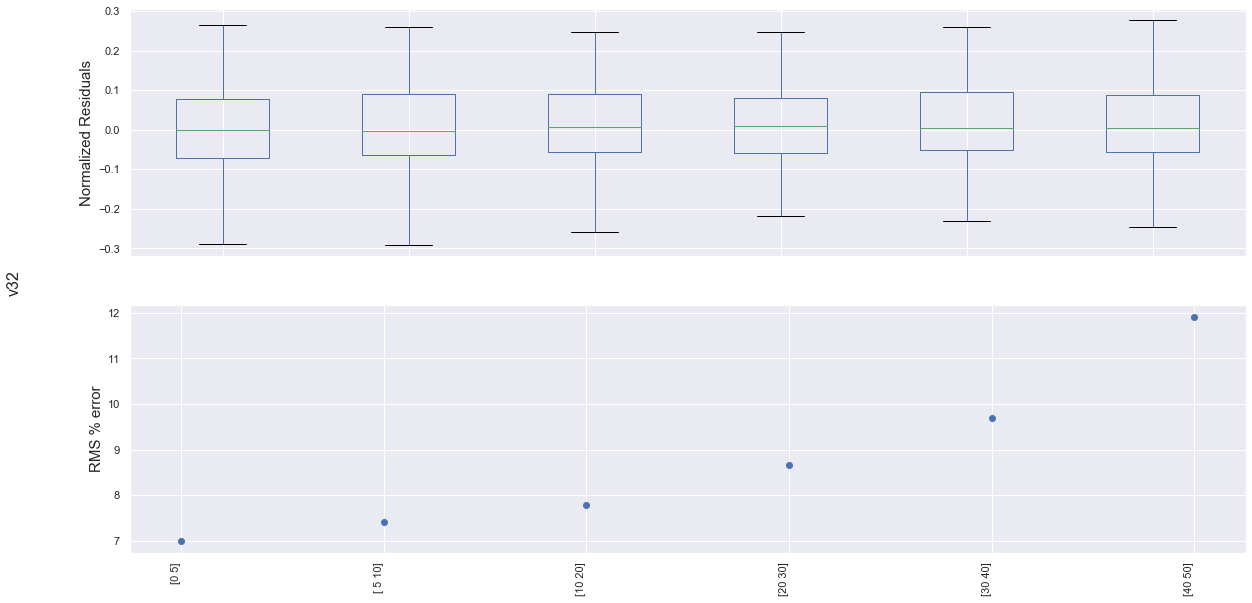

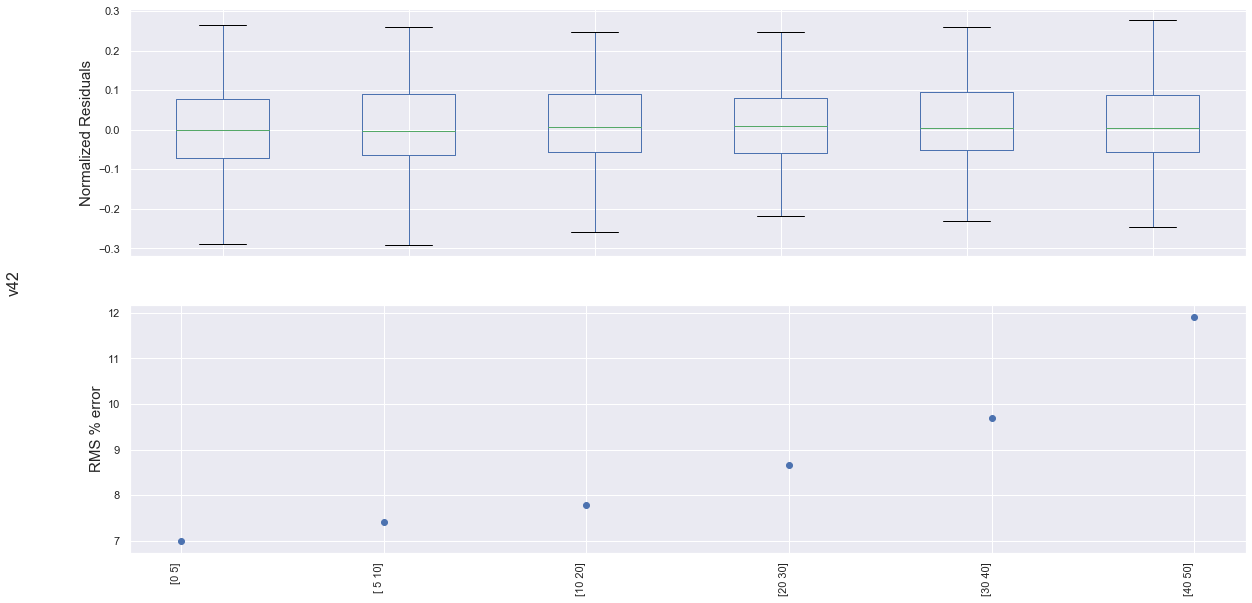

In [78]:
%matplotlib inline
for obs in active_obs_list['Pb-Pb-2760']:
    plot_rmse_bp(obs)